Praktikum 2


Langkah 1: Persiapan Environment


Langkah pertama adalah menyiapkan struktur direktori kerja dan memastikan file model tersedia.

1. Buat folder baru di komputer Anda dengan nama daynight-project.

2. Cari file model (day_night_model.h5) dan scaler (scaler.pkl) hasil training dari praktikum sebelumnya.

3. Pindahkan kedua file tersebut ke dalam folder daynight-project.

4. Buka terminal (Git Bash atau CMD), lalu arahkan direktori ke folder tersebut.

Langkah 2: Konfigurasi Server (app.py)


Diperlukan aplikasi web sederhana menggunakan Flask untuk menangani request gambar dari pengguna.

1. Buat file baru bernama app.py di dalam folder proyek.

2. Salin kode berikut ke dalamnya (kode ini memuat model dan melakukan preprocessing HOG yang sama persis dengan saat training):

In [ ]:
import os
import numpy as np
import cv2
import pickle
import tensorflow as tf
from flask import Flask, request, render_template_string
from skimage.feature import hog

app = Flask(__name__)

# Load Model & Scaler
MODEL_PATH = 'day_night_model.h5'
SCALER_PATH = 'scaler.pkl'

try:
    model = tf.keras.models.load_model(MODEL_PATH)
    with open(SCALER_PATH, 'rb') as f:
        scaler = pickle.load(f)
    print("✅ System Loaded Successfully")
except Exception as e:
    print(f"❌ Error loading system: {e}")

def preprocess_image(image_bytes):
    # Decode gambar
    nparr = np.frombuffer(image_bytes, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    
    # Preprocessing (Harus sama persis dengan Training)
    img = cv2.resize(img, (256, 256))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    hog_feat = hog(gray, orientations=9, pixels_per_cell=(8,8),
                   cells_per_block=(2,2), block_norm='L2-Hys',
                   visualize=False, feature_vector=True)
                   
    return scaler.transform(hog_feat.reshape(1, -1))

@app.route('/', methods=['GET'])
def home():
    return render_template_string('''
    <div style="text-align:center; padding:50px;">
        <h1>Day vs Night Classifier</h1>
        <form action="/predict" method="post" enctype="multipart/form-data">
            <input type="file" name="file" required><br><br>
            <button type="submit">Prediksi</button>
        </form>
    </div>
    ''')

@app.route('/predict', methods=['POST'])
def predict():
    try:
        file = request.files['file']
        data = preprocess_image(file.read())
        prediction = model.predict(data)[0][0]
        
        label = "Day (Siang)" if prediction > 0.5 else "Night (Malam)"
        return f"<h2 style='text-align:center'>Hasil: {label}</h2><center><a href='/'>Kembali</a></center>"
    except Exception as e:
        return f"Error: {e}"

if __name__ == '__main__':
    # Port 7860 wajib untuk Hugging Face Spaces
    app.run(host='0.0.0.0', port=7860)

Langkah 3: Konfigurasi Dependencies (requirements.txt)


Agar server cloud tahu library apa saja yang dibutuhkan, perlu membuat daftar dependencies.

Buat file baru bernama requirements.txt.

Isi file tersebut dengan daftar library berikut:

In [ ]:
flask
tensorflow-cpu
numpy
scikit-learn
scikit-image
opencv-python-headless
gunicorn

Langkah 4: Konfigurasi Docker (Dockerfile)


Dockerfile berisi instruksi untuk membangun image sistem operasi yang akan menjalankan aplikasi kita.

Buat file bernama Dockerfile (tanpa ekstensi file apapun).

Salin konfigurasi berikut:

In [ ]:
# Base Image Python 3.9 Slim
FROM python:3.9-slim

# Install Library Sistem untuk OpenCV (Debian Bookworm/Trixie Compatible)
RUN apt-get update && apt-get install -y \
    libgl1 \
    libglib2.0-0 \
    && rm -rf /var/lib/apt/lists/*

# Setup User Non-Root (Standar Keamanan HF)
RUN useradd -m -u 1000 user
USER user
ENV PATH="/home/user/.local/bin:$PATH"

# Setup Direktori Kerja
WORKDIR /app

# Install Dependencies
COPY --chown=user ./requirements.txt requirements.txt
RUN pip install --no-cache-dir --upgrade -r requirements.txt

# Copy File Aplikasi
COPY --chown=user . /app

# Expose Port & Jalankan
EXPOSE 7860
CMD ["python", "app.py"]

Langkah 5: Setup Hugging Face Space


Langkah 6: Upload ke Cloud (Hugging Face)


Langkah 7: Pengujian dan Hasil Akhir

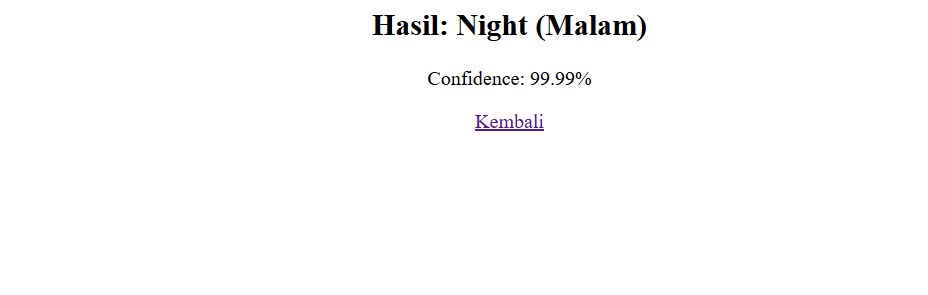